In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
SEED = 1234567890
np.random.seed(SEED)

#### Code 8.1

In [4]:
num_weeks = int(1e5)
positions = np.empty(num_weeks, dtype=np.int64)
current = 9

for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    proposal %= 10
    
    #move?
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if np.random.uniform() < prob_move else current

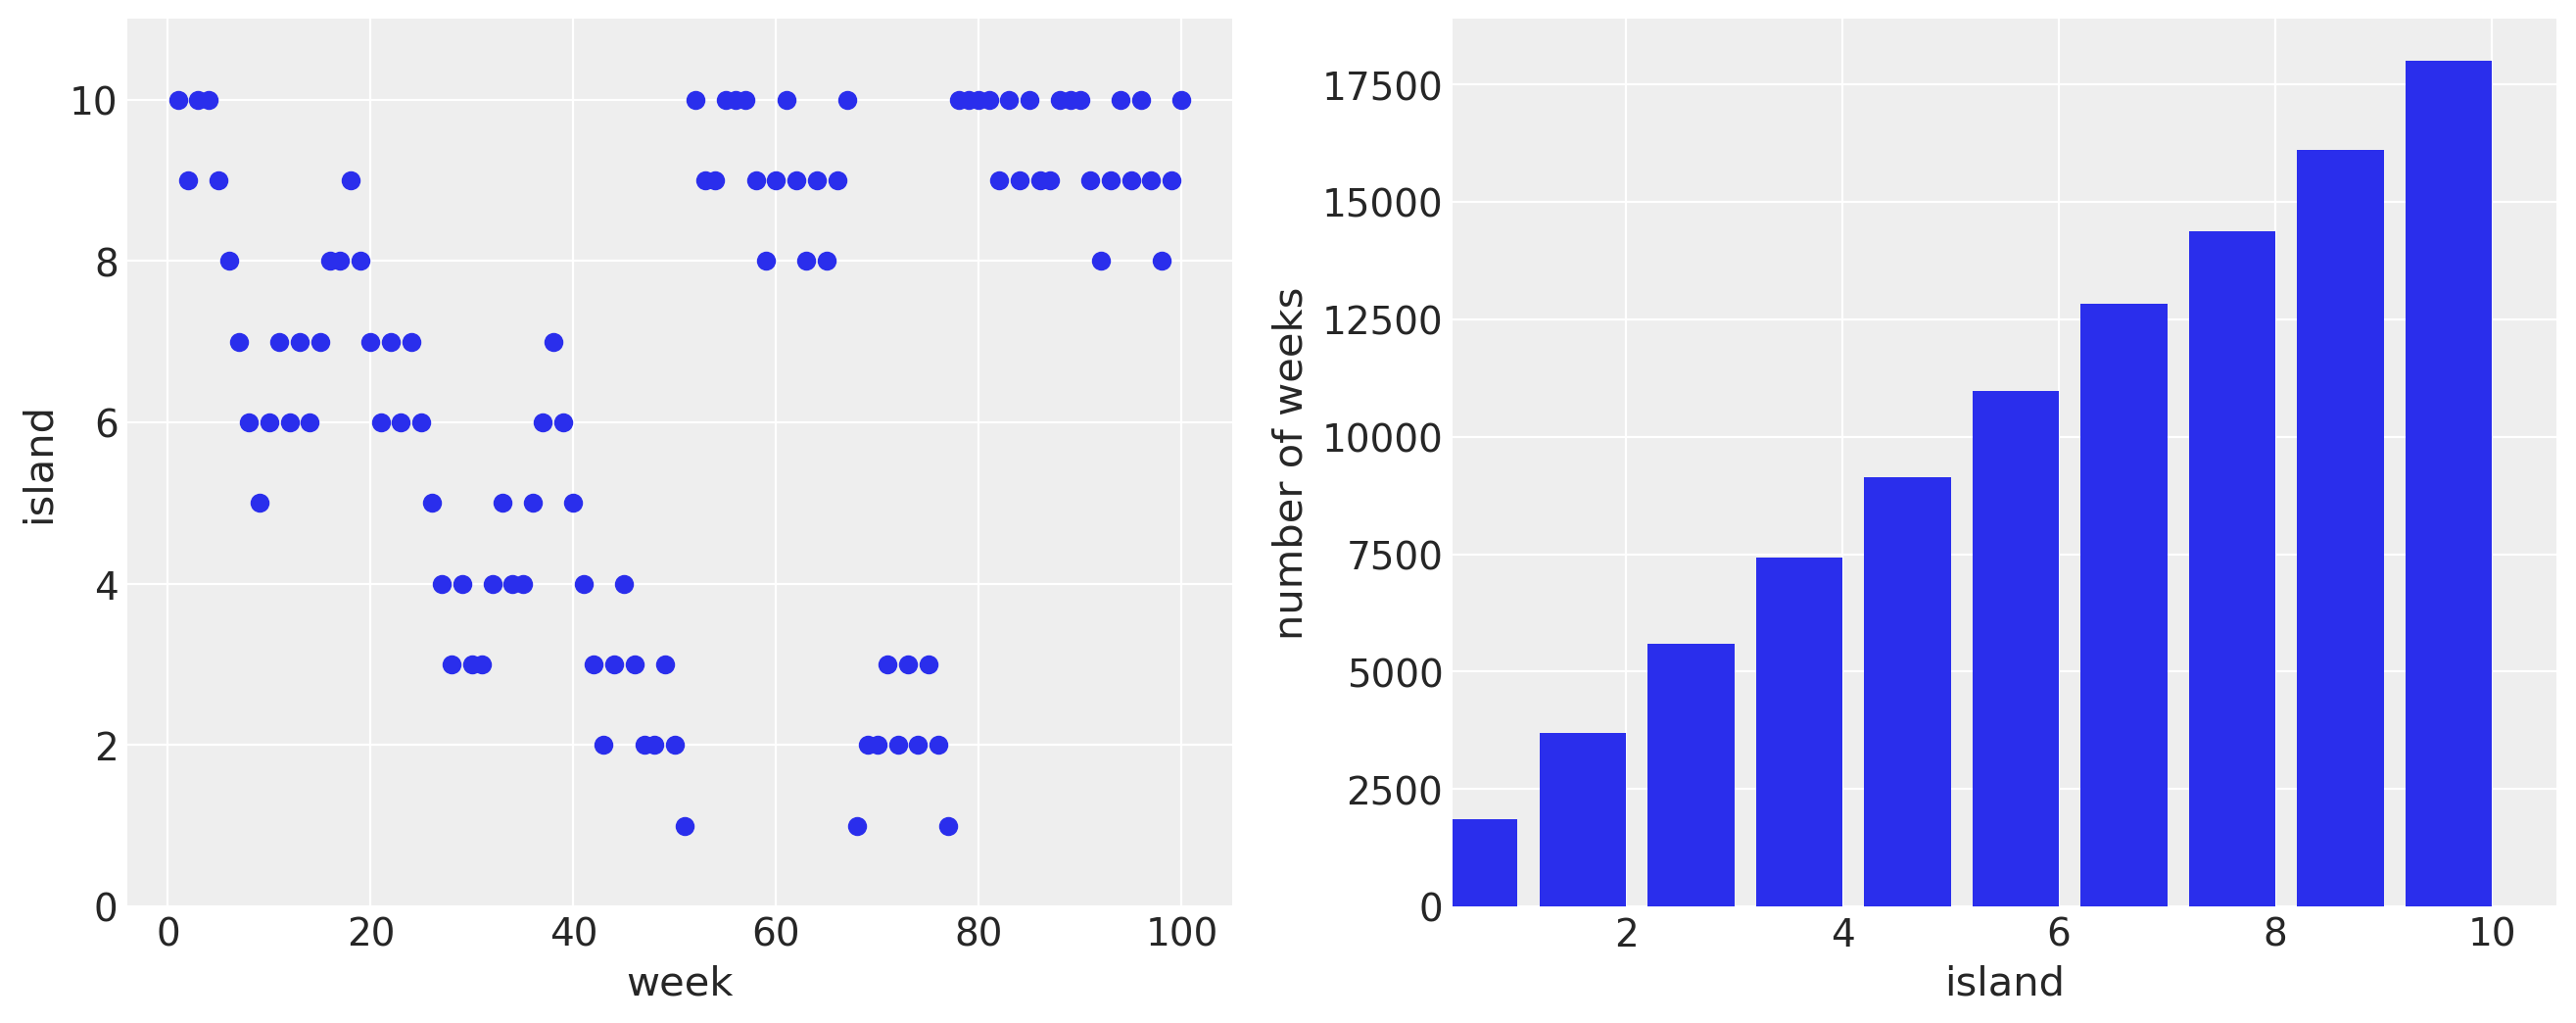

In [5]:
_, (week_ax, island_ax) = plt.subplots(ncols=2, figsize=(16, 6))

week_ax.scatter(np.arange(100) + 1, positions[:100] + 1);

week_ax.set_xlabel('week');
week_ax.set_ylim(0, 11);
week_ax.set_ylabel('island');

island_ax.bar(np.arange(10) + 0.6, np.bincount(positions));

island_ax.set_xlim(0.4, 10.6);
island_ax.set_xlabel('island');
island_ax.set_ylabel('number of weeks');

#### Code 8.2

In [6]:
rugged_df = (pd.read_csv('Data/rugged.csv', sep=';')
               .assign(log_gdp=lambda df: np.log(df.rgdppc_2000))
               .dropna(subset=['log_gdp']))

#### Code 8.3

In [7]:
with pm.Model() as m8_1_map:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.Uniform('sigma', 0., 10.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [8]:
with m8_1_map:
    map_8_1 = pm.find_MAP()

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -246.89, ||grad|| = 0.297: 100%|██████████| 36/36 [00:00<00:00, 1086.25it/s]           


In [9]:
map_8_1

{'a': array(9.22278924),
 'bA': array(-1.94694634),
 'bAR': array(0.39290435),
 'bR': array(-0.20265346),
 'sigma': array(0.9326788),
 'sigma_interval__': array(-2.27437128)}

#### Code 8.5

In [11]:
with pm.Model() as m8_1:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.HalfCauchy('sigma', 2.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [12]:
with  m8_1:
    trace_8_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 618.20draws/s]


In [13]:
pm.summary(trace_8_1, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,9.00,9.44,914.68,1.0
bR,-0.20,0.08,0.00,-0.32,-0.09,872.92,1.0
bA,-1.94,0.22,0.01,-2.30,-1.59,964.49,1.0
bAR,0.39,0.13,0.00,0.19,0.60,912.76,1.0
sigma,0.95,0.05,0.00,0.86,1.03,1630.54,1.0


#### Code 8.7

In [14]:
with m8_1:
    trace_8_1_4_chains = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 604.28draws/s]


In [18]:
az.summary(trace_8_1_4_chains, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.22,0.14,0.00,0.0,9.01,9.46,1033.0,1033.0,1036.0,1226.0,1.0
bR,-0.20,0.08,0.00,0.0,-0.33,-0.09,999.0,992.0,1000.0,1327.0,1.0
bA,-1.94,0.23,0.01,0.0,-2.32,-1.60,1002.0,1002.0,1002.0,1215.0,1.0
bAR,0.40,0.13,0.00,0.0,0.20,0.61,1007.0,989.0,1007.0,1103.0,1.0
sigma,0.95,0.05,0.00,0.0,0.87,1.03,1460.0,1460.0,1444.0,1057.0,1.0


#### Code 8.8

In [19]:
trace_8_1_df = pm.trace_to_dataframe(trace_8_1)

In [20]:
trace_8_1_df.head()

,a,bR,bA,bAR,sigma
0,8.786572,0.018579,-1.058387,-0.060584,1.059046
1,8.678873,0.072943,-1.291372,0.076082,1.025614
2,8.815340,0.006843,-1.412377,0.127806,0.971882
3,8.875567,0.015835,-1.247205,0.043581,0.955478
4,9.103524,-0.059070,-1.700822,0.238832,0.960887


#### Code 8.9 and 8.10

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


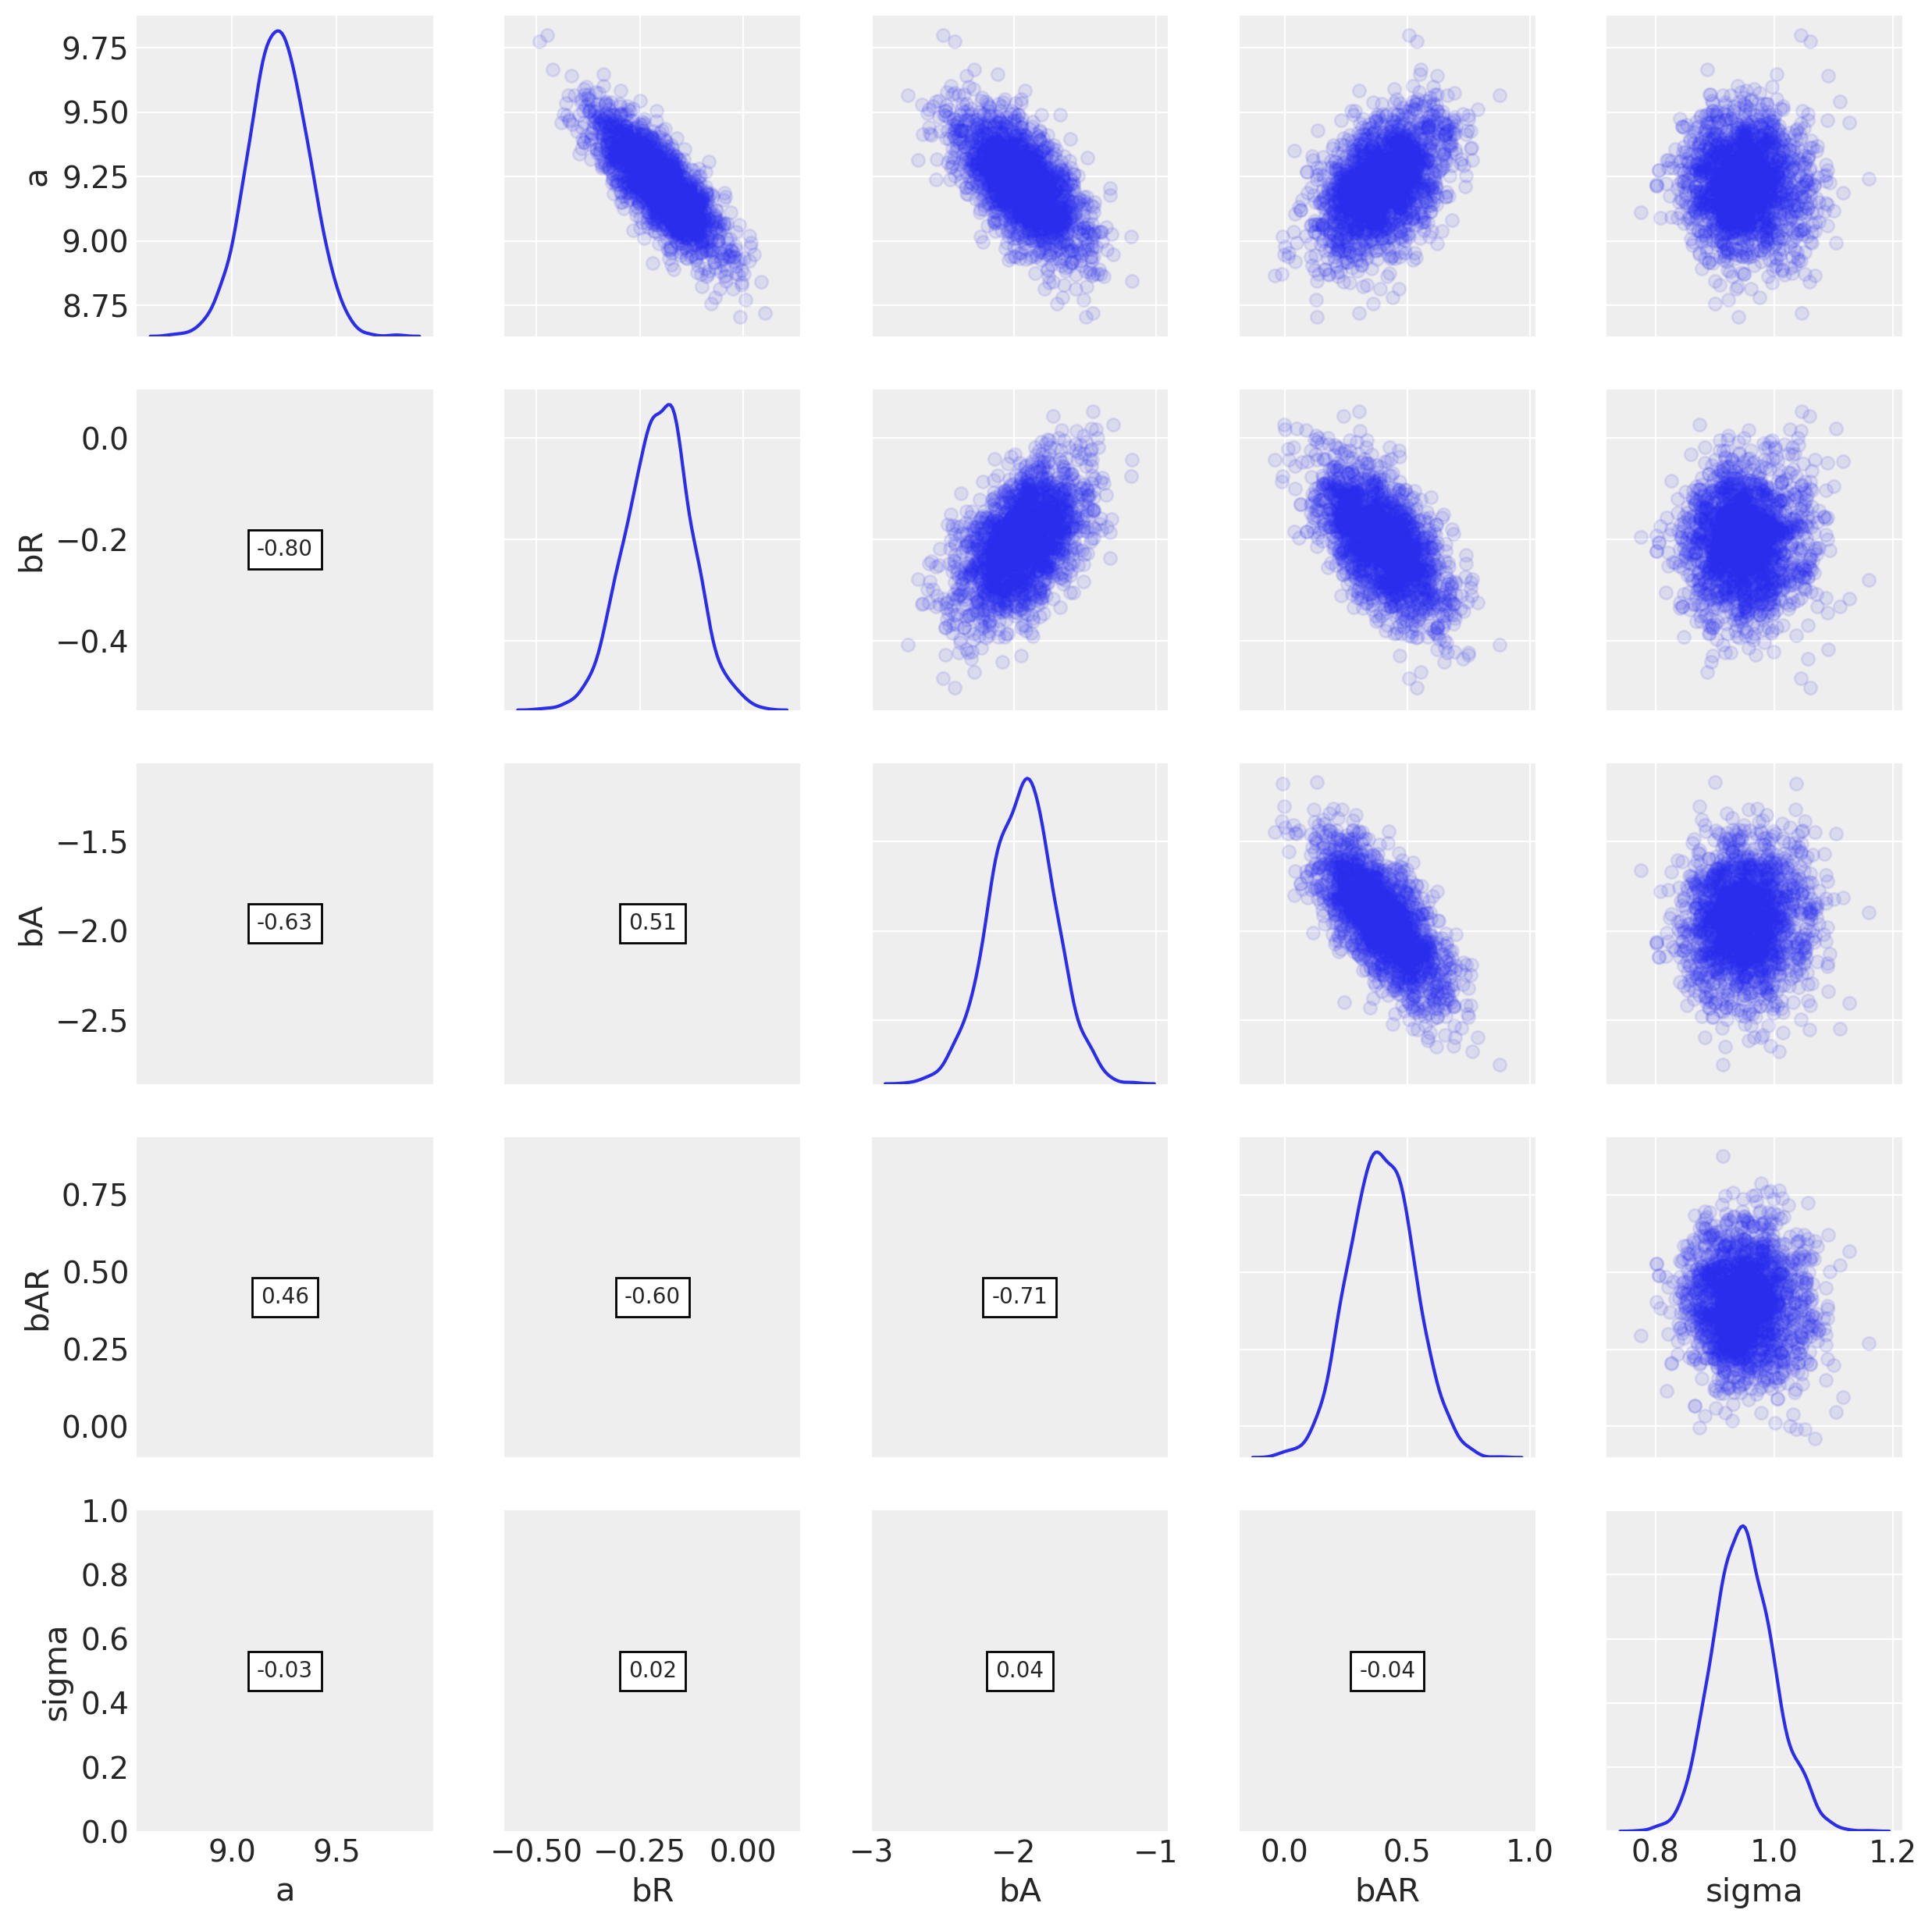

In [21]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

trace_8_1_df = pm.trace_to_dataframe(trace_8_1_4_chains)
grid = (sns.PairGrid(trace_8_1_df,
                     x_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     y_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

#### Code 8.11

In [22]:
m8_1.logp({
    varname: trace_8_1[varname].mean()
        for varname in trace_8_1.varnames})

array(-246.01972944)

The computation of DIC has been deprecated and is no longer available in PyMC3

In [25]:
az.waic(trace_8_1)

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:993: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


waic           469.161
waic_se        14.8698
p_waic         5.06073
warning           True
waic_scale    deviance
dtype: object

#### Code 8.12

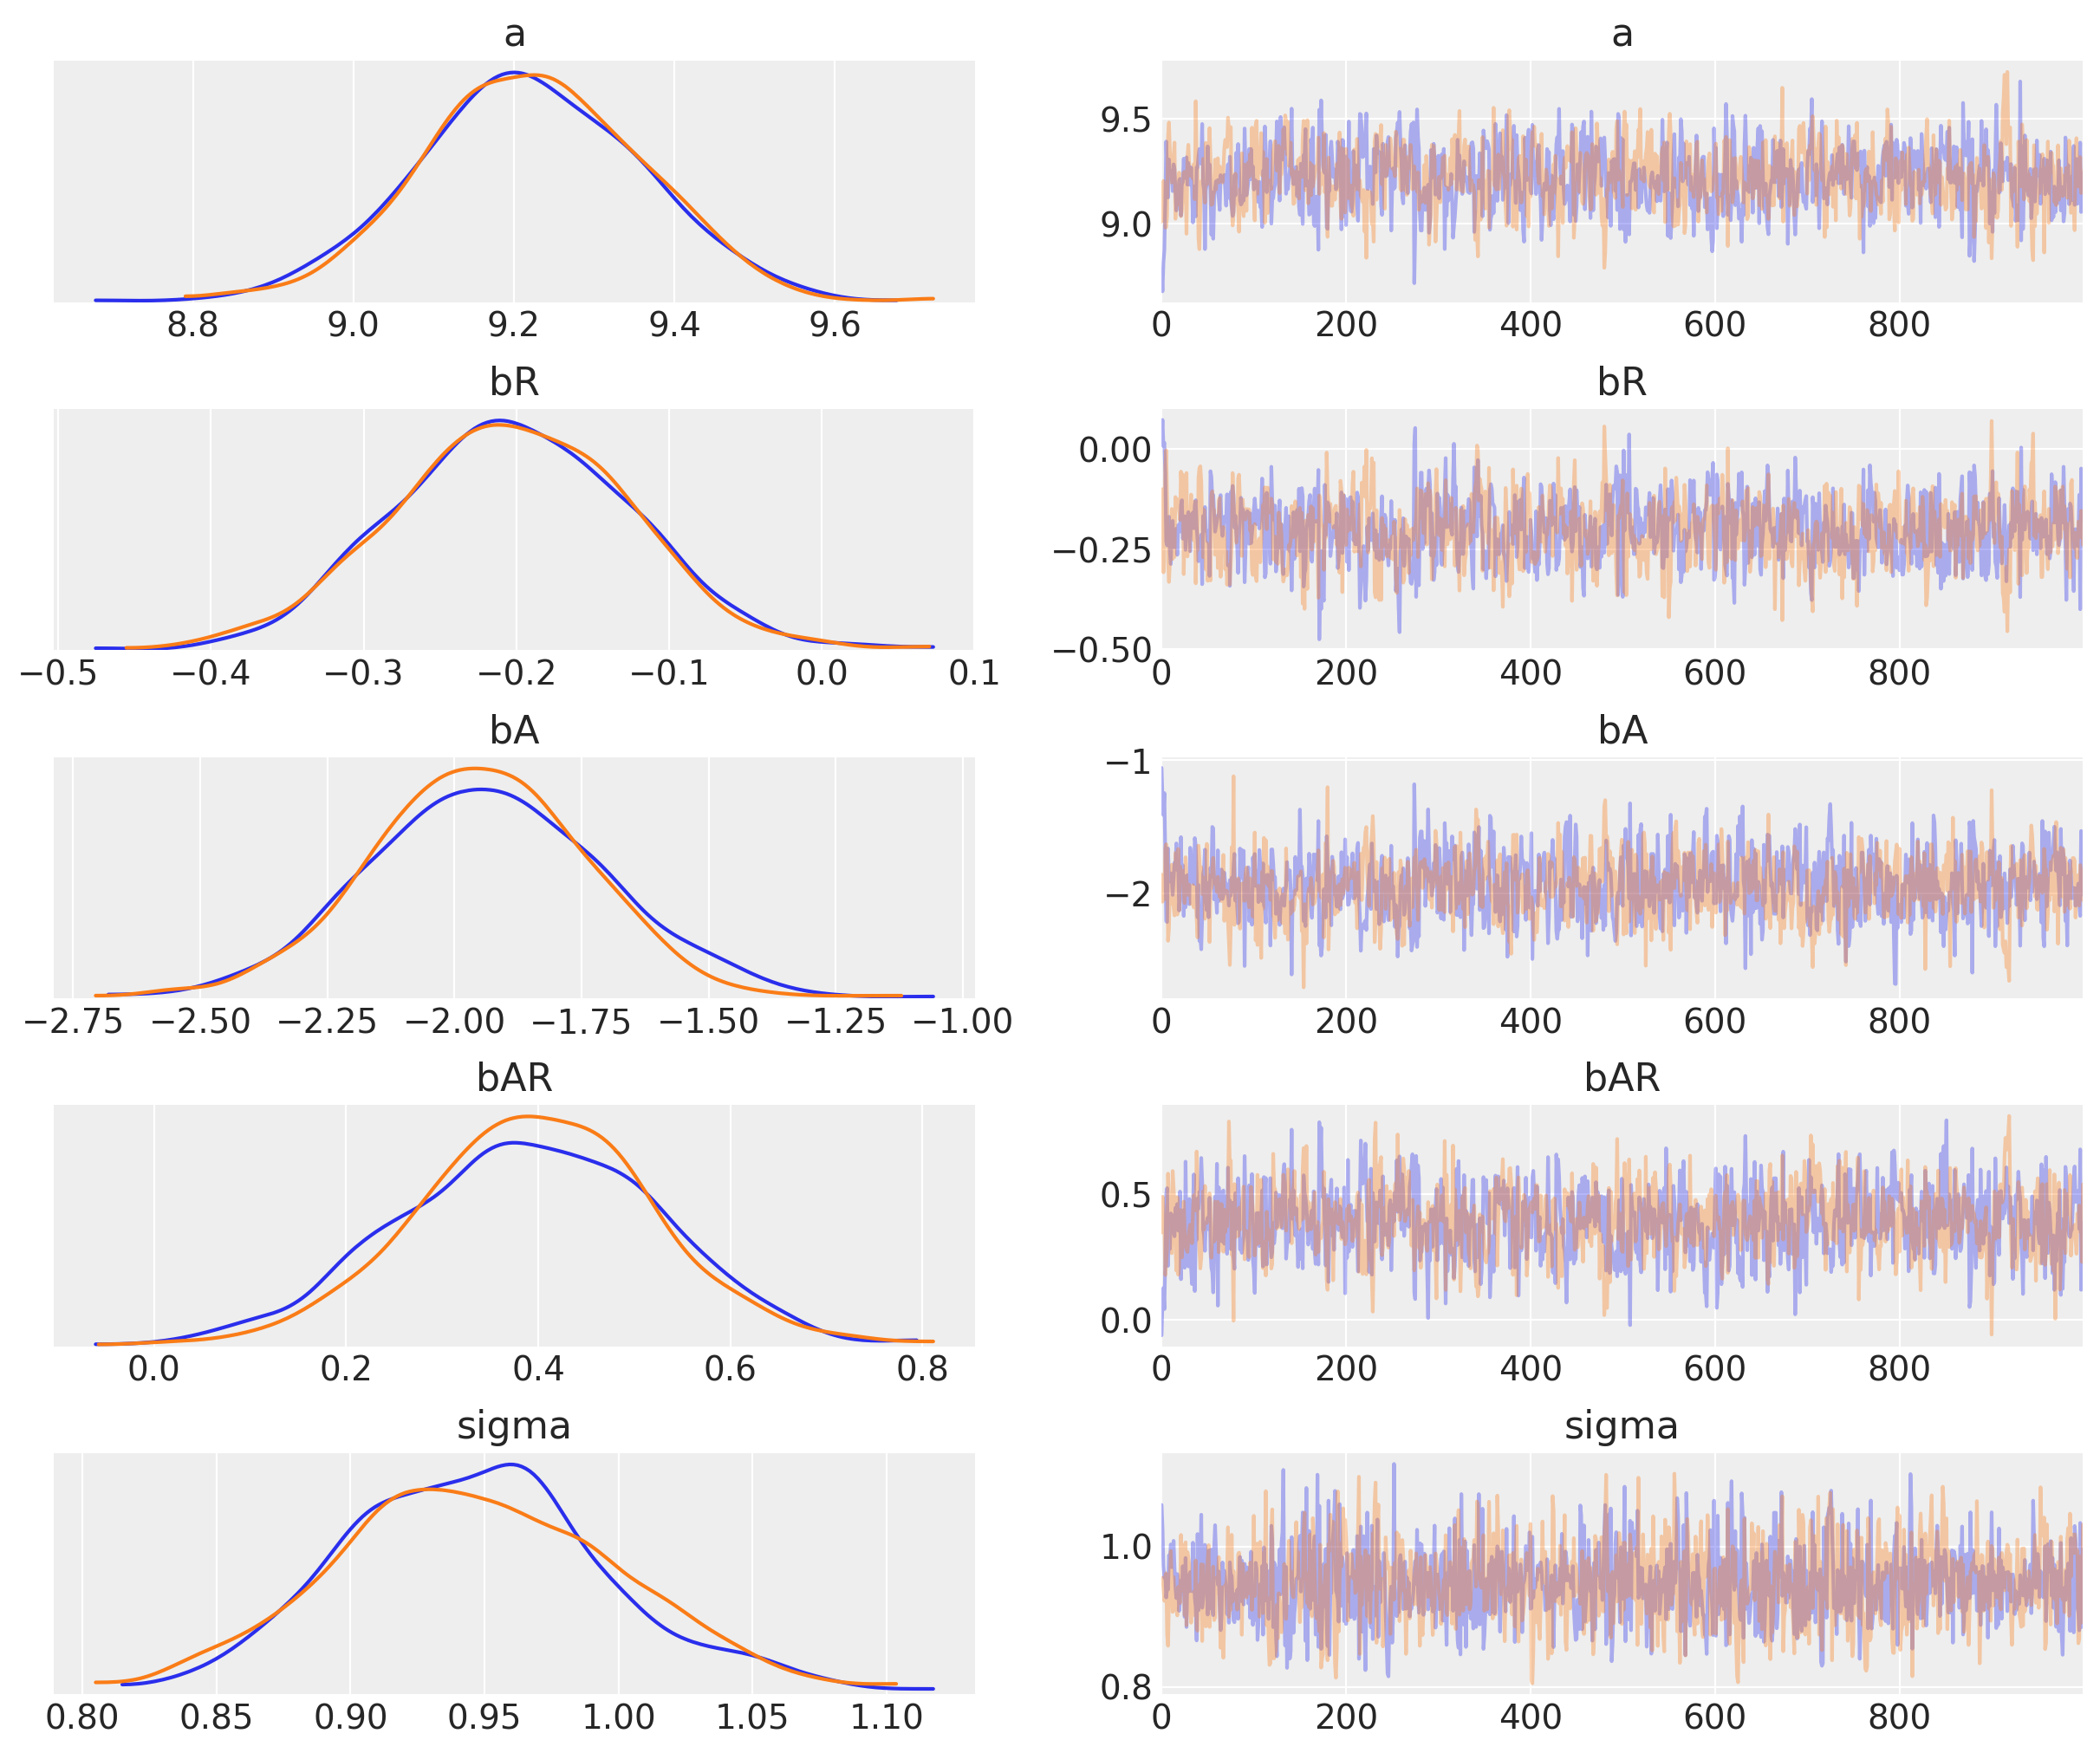

In [26]:
az.plot_trace(trace_8_1);

#### Code 8.13

In [27]:
y = np.array([-1., 1.])

with pm.Model() as m8_2:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [28]:
with m8_2:
    trace_8_2 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:35<00:00, 224.92draws/s] 
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6105366882493044, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


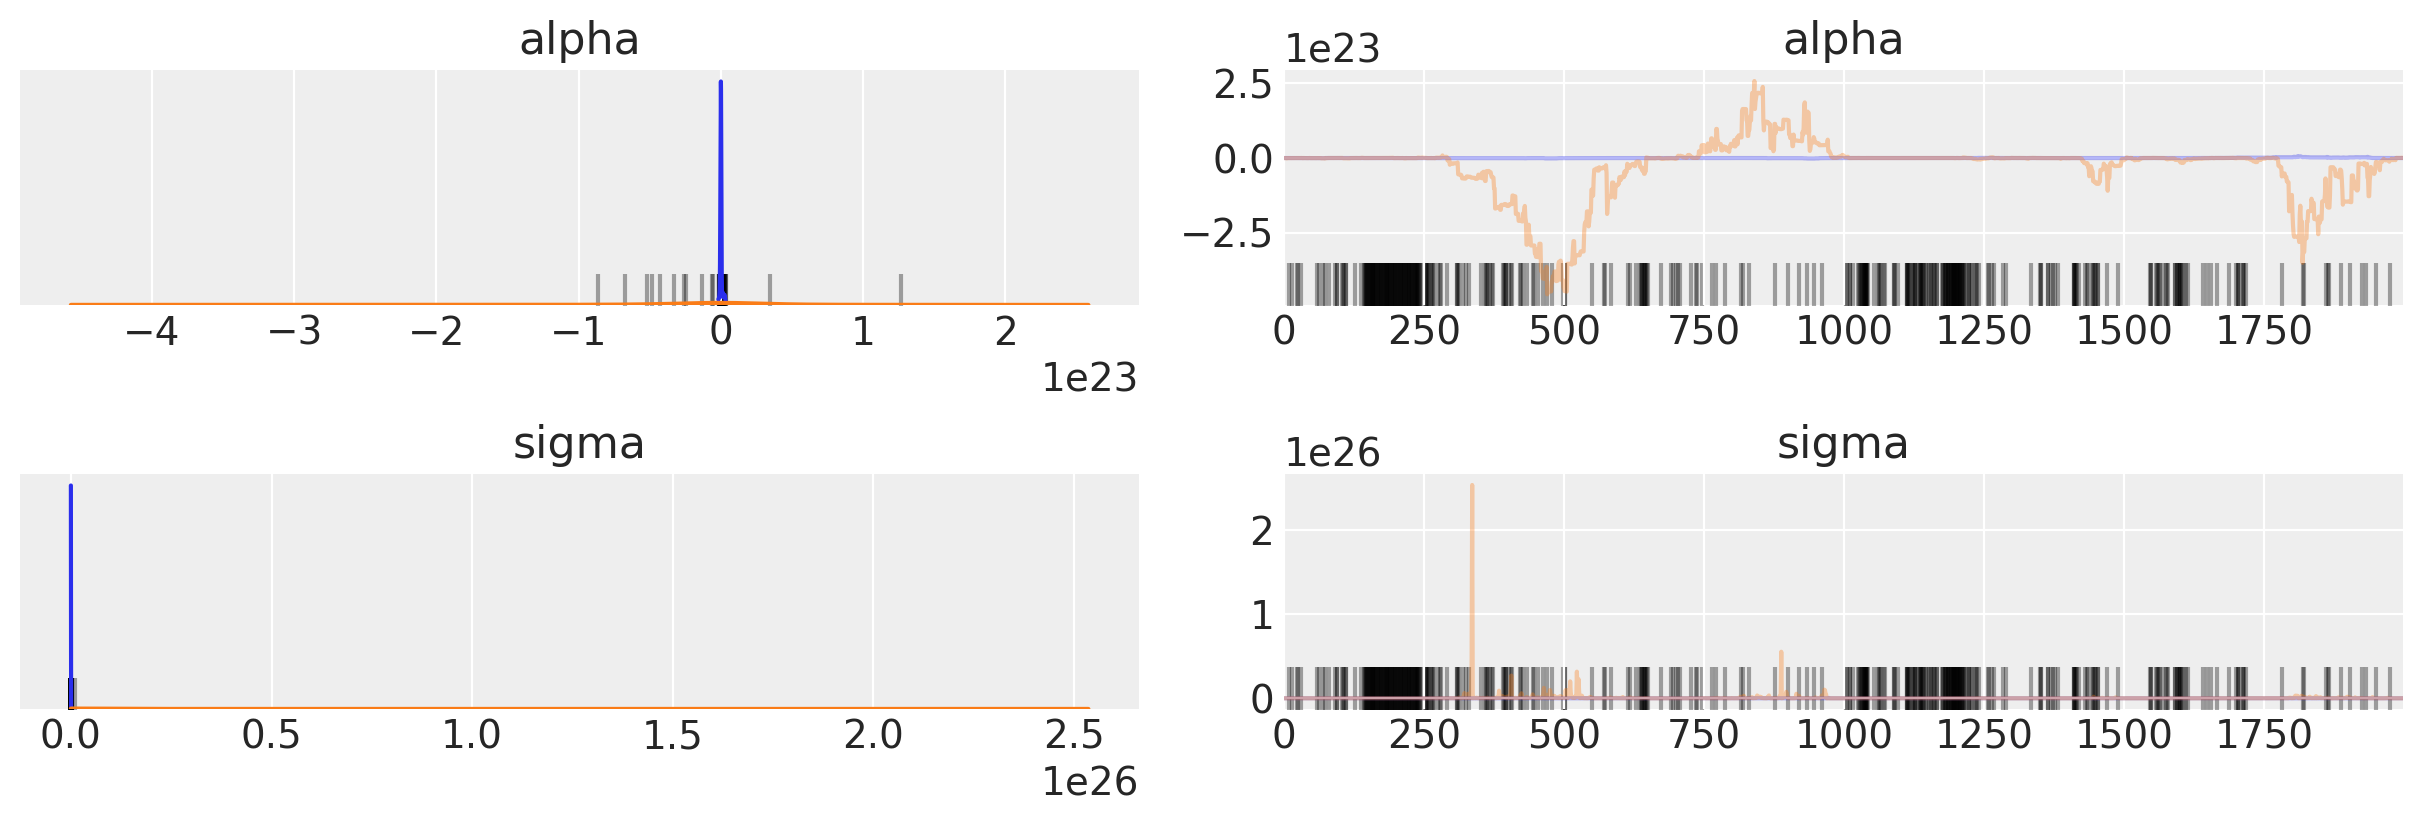

In [29]:
az.plot_trace(trace_8_2);

In [34]:
az.effective_sample_size(trace_8_2)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 16.95
    sigma    float64 5.042

#### Code 8.14

In [35]:
az.summary(trace_8_2, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.606191e+22,7.349687e+22,1.526013e+22,1.092917e+22,-6.979635e+22,5.901041e+22,23.0,23.0,17.0,11.0,1.31
sigma,2.541397e+23,4.289187e+24,1.309084e+23,9.259135e+22,3.516358e+17,1.900958e+23,1074.0,1074.0,5.0,50.0,1.33


#### Code 8.15

In [36]:
with pm.Model() as m8_3:
    alpha = pm.Normal('alpha', 1., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [37]:
with m8_3:
    trace_8_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2060.14draws/s]
The acceptance probability does not match the target. It is 0.8961048313756717, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [38]:
az.summary(trace_8_3, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.09,1.73,0.12,0.08,-2.56,2.44,218.0,218.0,303.0,149.0,1.01
sigma,2.09,1.92,0.10,0.07,0.51,3.75,364.0,364.0,420.0,491.0,1.00


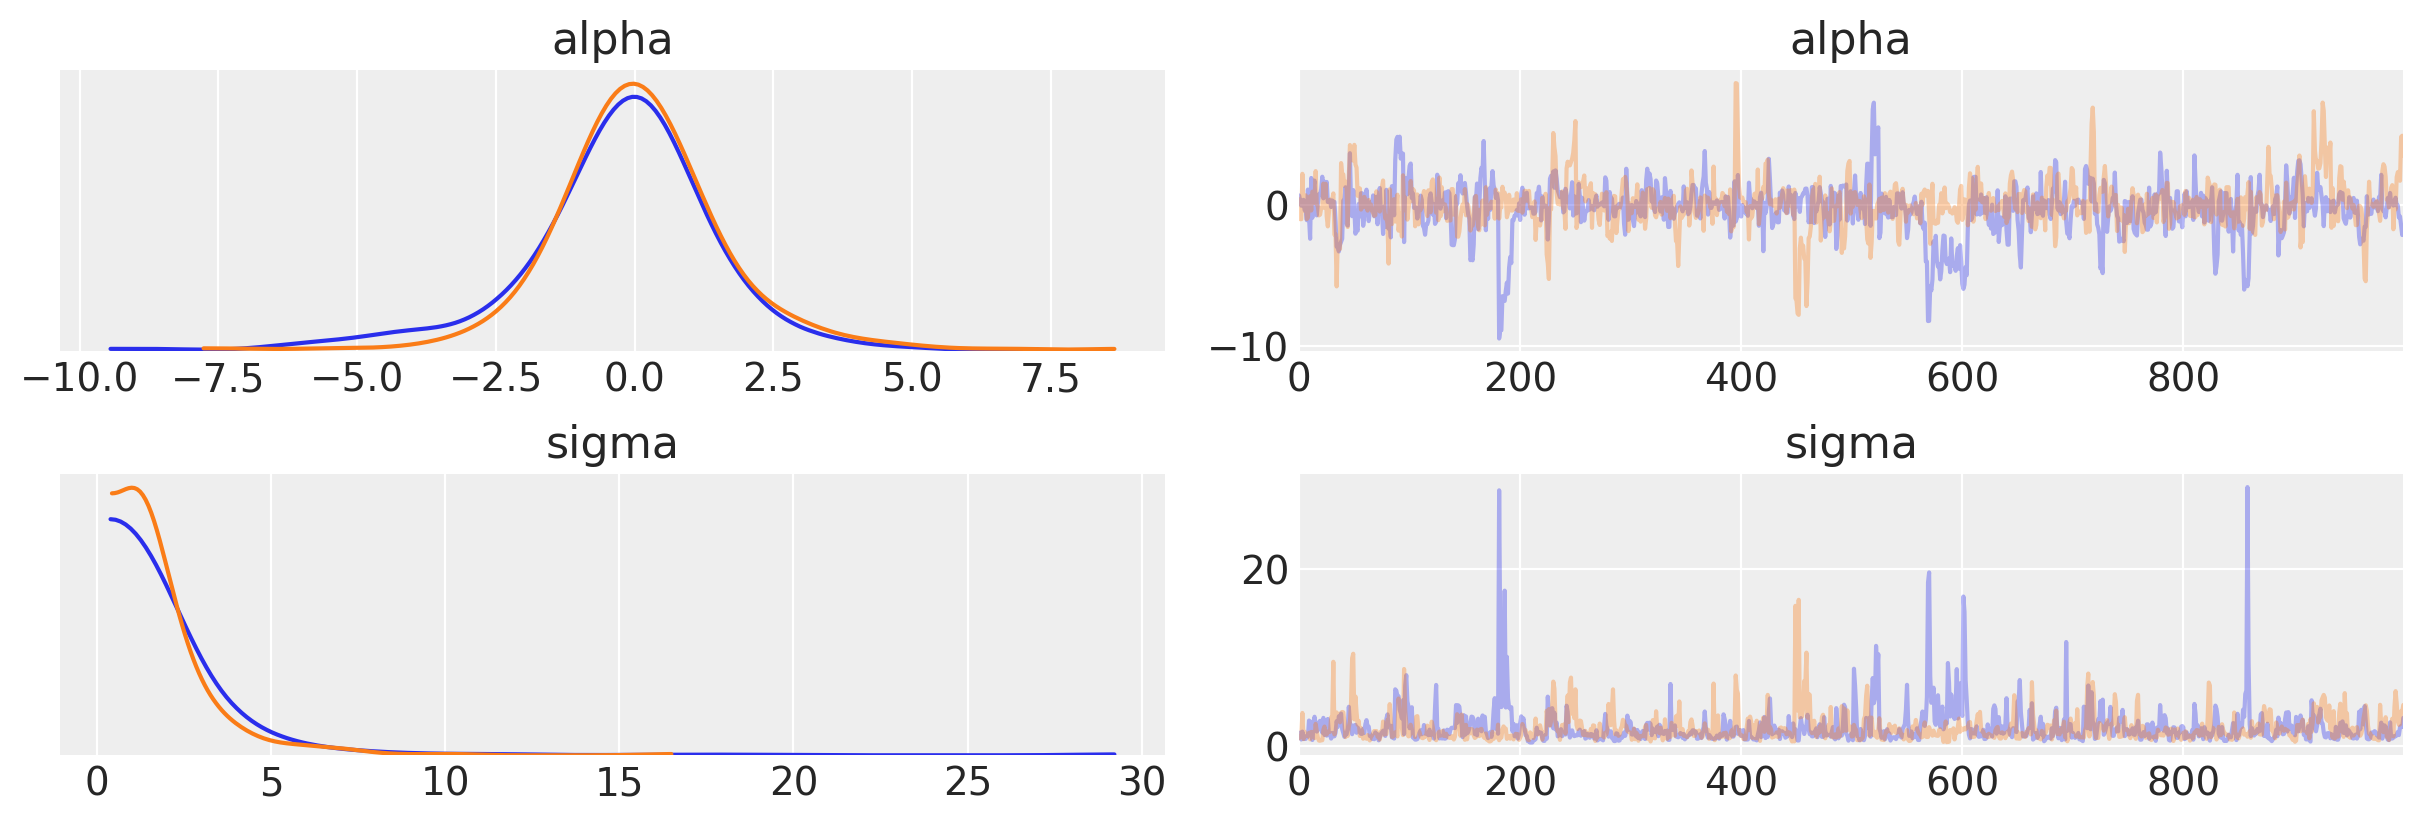

In [39]:
az.plot_trace(trace_8_3);

#### Code 8.16

In [40]:
y = sp.stats.cauchy.rvs(0., 5., size=int(1e4))
mu = y.cumsum() / (1 + np.arange(int(1e4)))

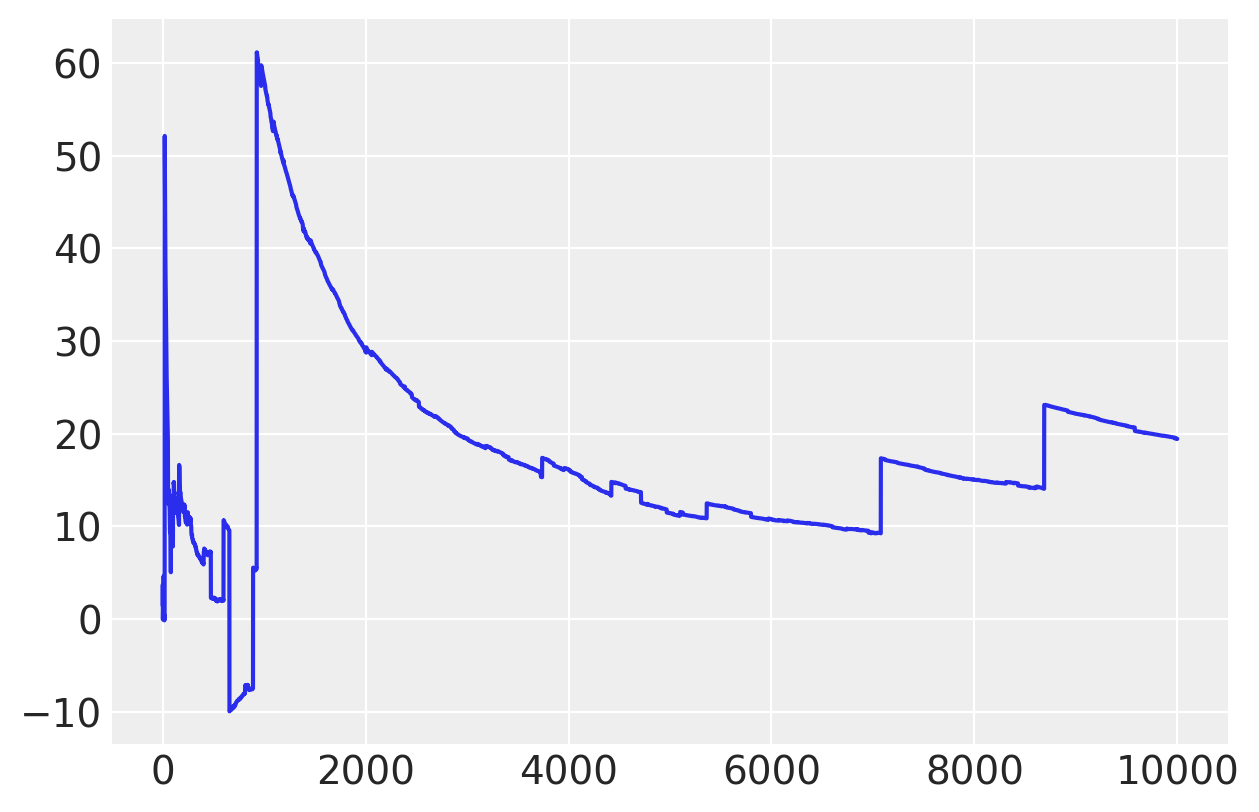

In [41]:
plt.plot(mu);

#### Code 8.17

In [42]:
y = np.random.normal(0., 1., size=100)

#### Code 8.18

In [43]:
with pm.Model() as m8_4:
    a1 = pm.Flat('a1')
    a2 = pm.Flat('a2')
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [44]:
with m8_4:
    trace_8_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:22<00:00, 10.94draws/s]
The acceptance probability does not match the target. It is 0.4489770572349002, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6261982508792466, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [47]:
az.summary(trace_8_4, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,447.83,1081.02,669.25,539.29,-1318.05,1863.75,3.0,3.0,3.0,12.0,1.71
a2,-447.88,1081.02,669.25,539.29,-1863.82,1318.09,3.0,3.0,3.0,12.0,1.71
sigma,0.97,0.04,0.01,0.00,0.88,1.02,47.0,47.0,40.0,81.0,1.35


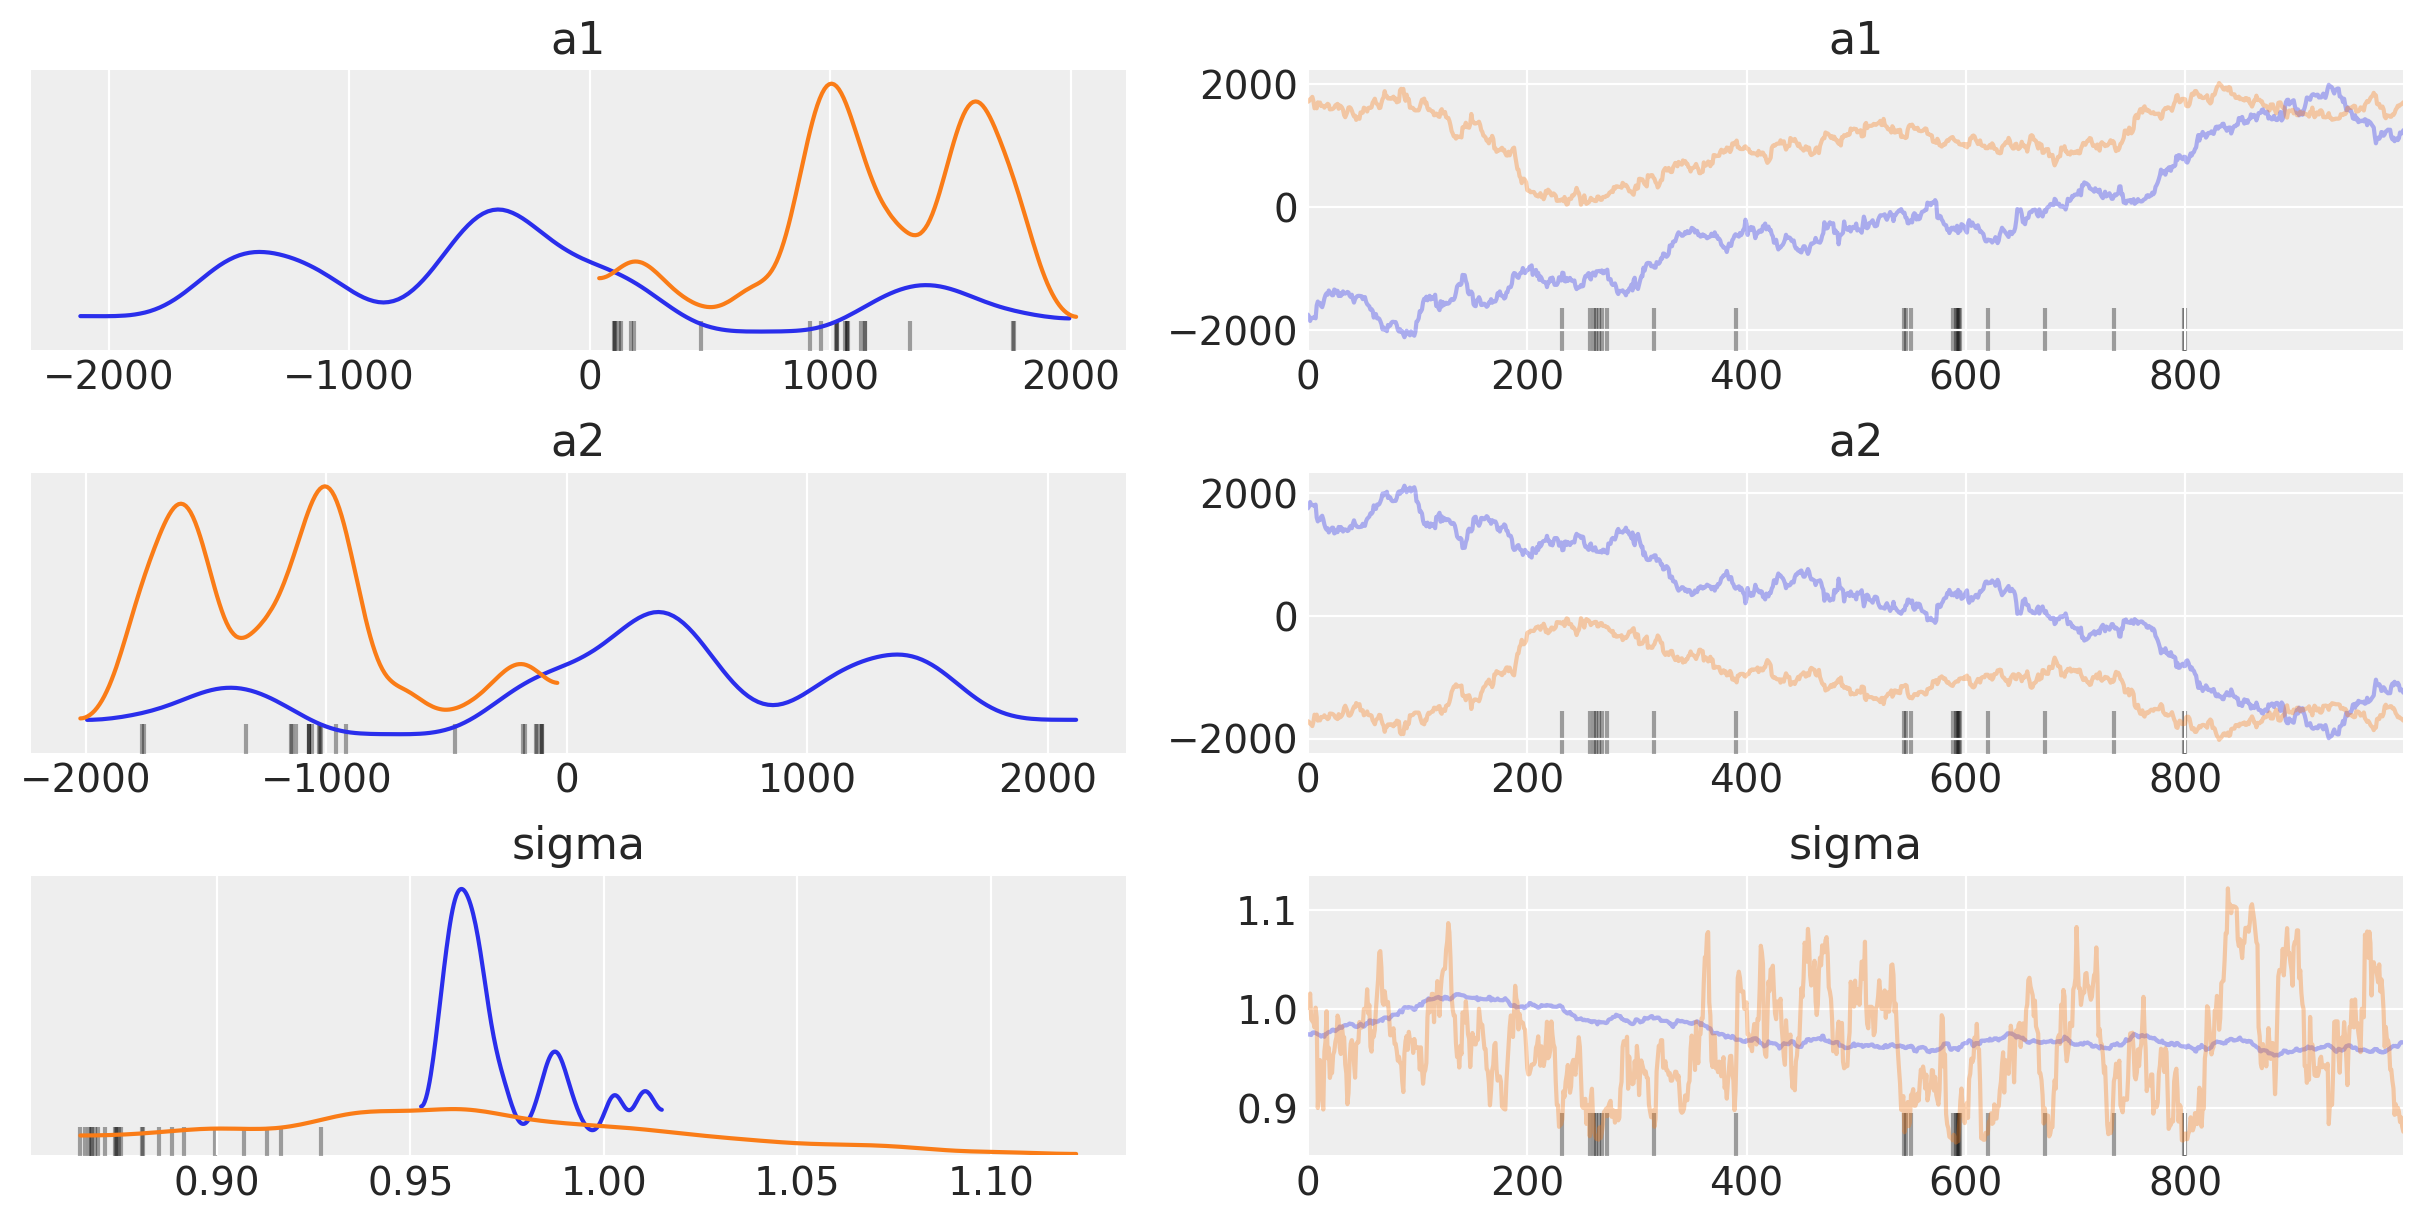

In [48]:
az.plot_trace(trace_8_4);

#### Code 8.19

In [49]:
with pm.Model() as m8_5:
    a1 = pm.Normal('a1', 0., 10.)
    a2 = pm.Normal('a2', 0., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [50]:
with m8_5:
    trace_8_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:50<00:00, 79.42draws/s]


In [51]:
az.summary(trace_8_5, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,-0.47,7.33,0.3,0.22,-12.35,10.69,580.0,580.0,572.0,805.0,1.0
a2,0.42,7.33,0.3,0.22,-11.02,12.03,580.0,580.0,573.0,805.0,1.0
sigma,0.96,0.07,0.0,0.00,0.86,1.08,790.0,785.0,795.0,827.0,1.0


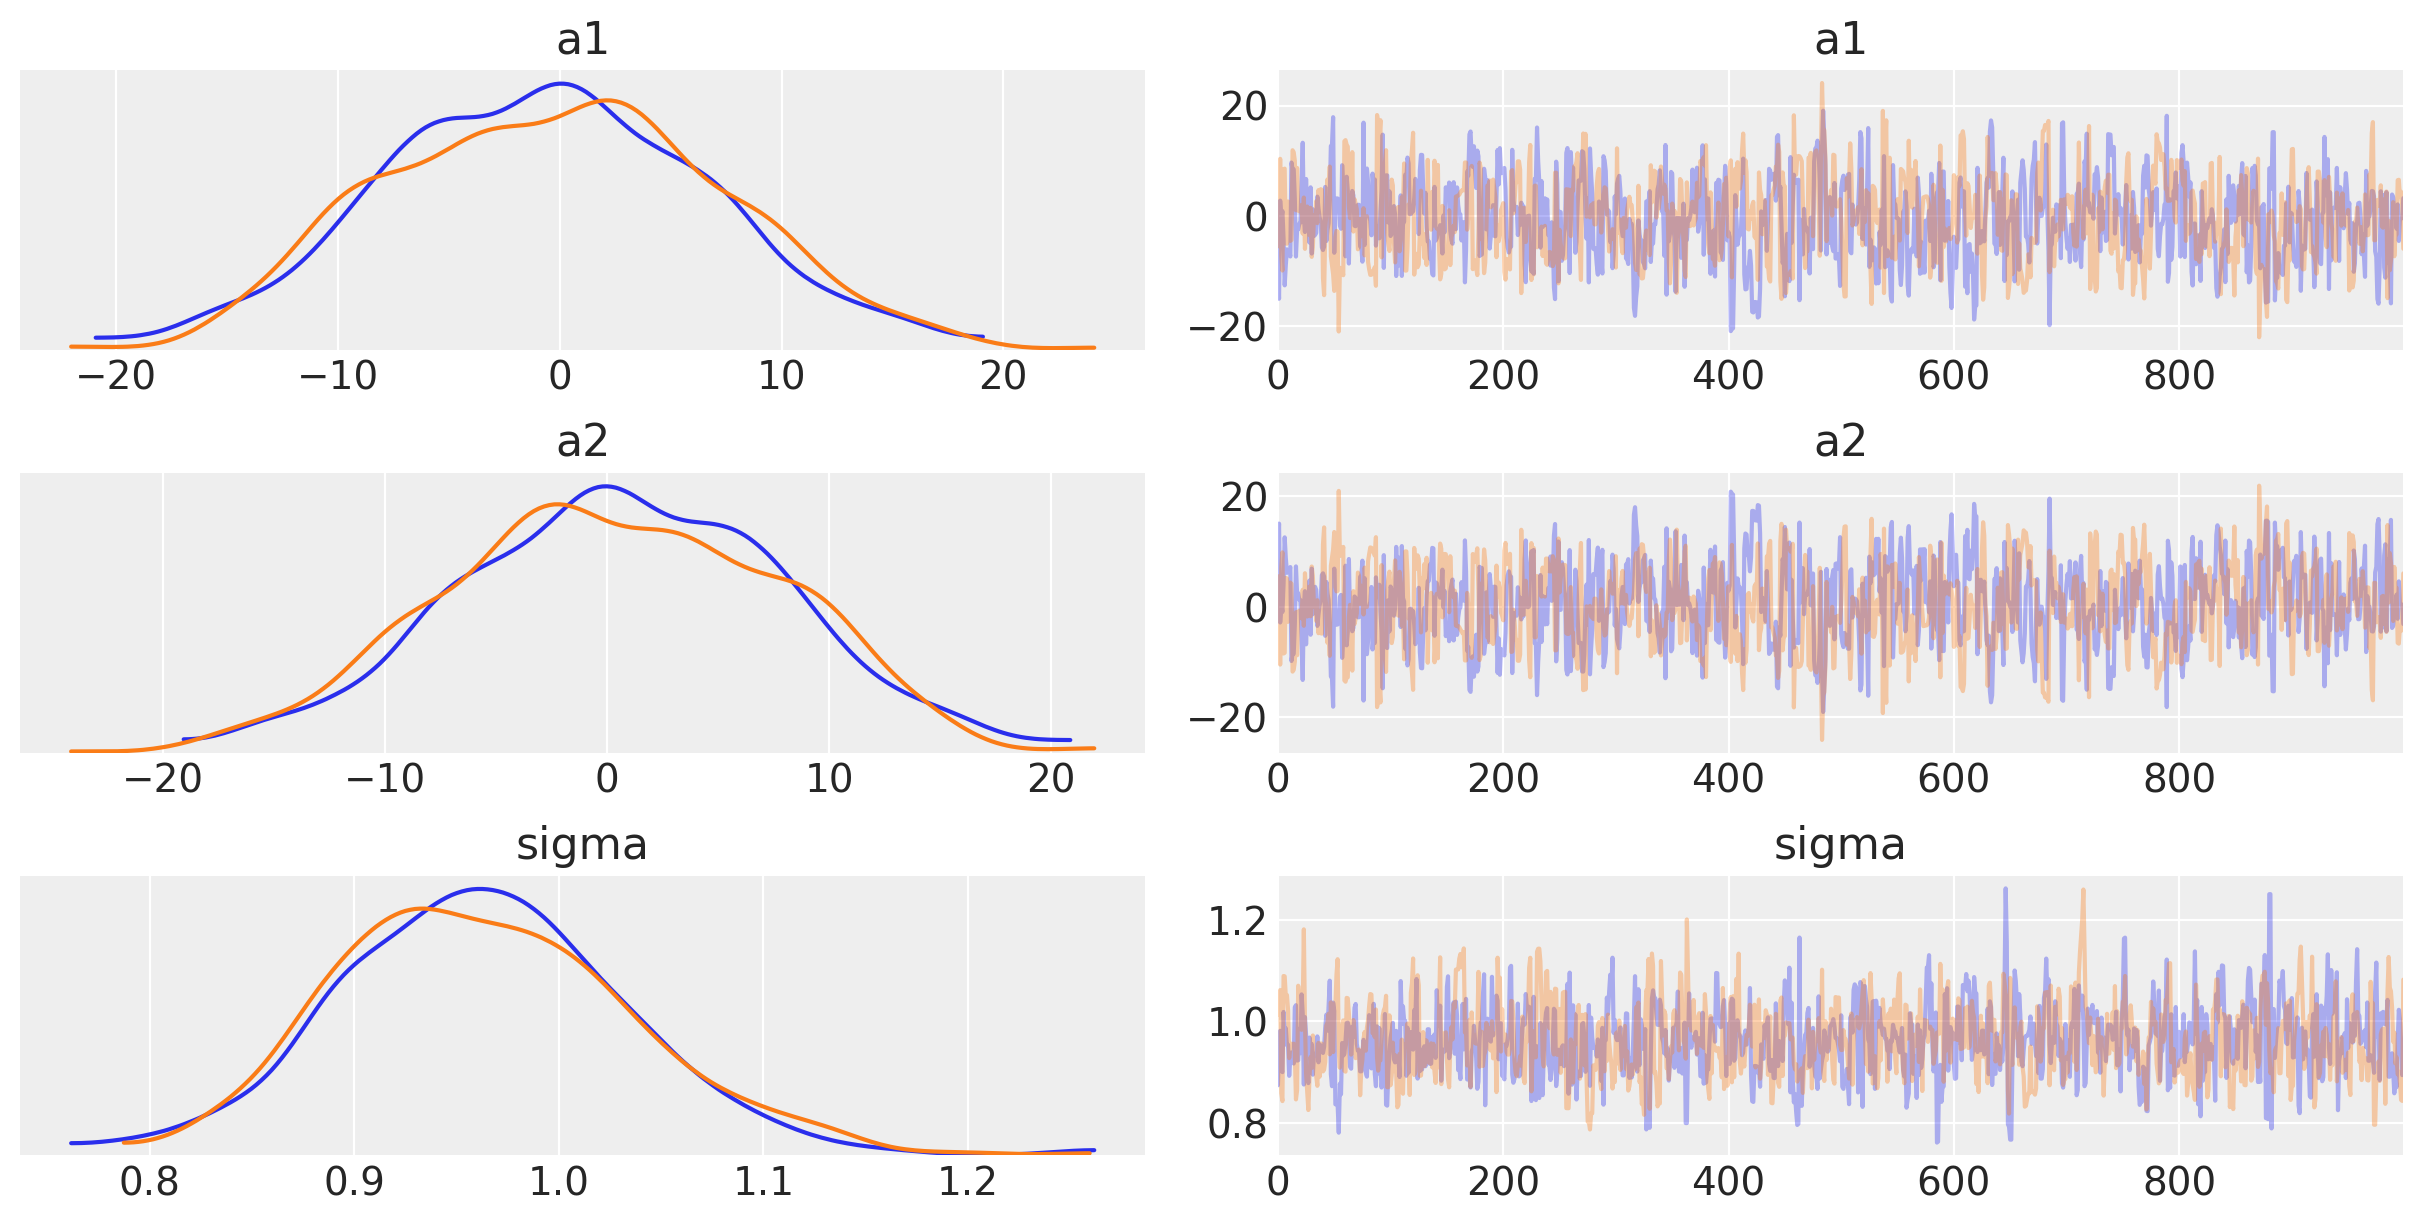

In [52]:
az.plot_trace(trace_8_5);

In [53]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.1
IPython 6.2.1
PyMC3 3.7.rc1
ArviZ 0.4.0
NumPy 1.15.4
SciPy 1.1.0
Matplotlib 3.0.2

